# 2. Data Preprocessing, Augmentation, and Model Training - Glute Bridge

**Objective:**
1.  Define a robust feature extraction function using `GeometryUtils`.
2.  Implement data augmentation to expand the small training dataset.
3.  Create `scikit-learn` pipelines that combine a `StandardScaler` and a classifier.
4.  Train and evaluate multiple classification algorithms using stratified k-fold cross-validation.
5.  Select the best model and save the trained pipeline(s) to `.pkl` files.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

## 2.1 Define Paths and Constants

In [ ]:

BASE_DATA_PATH = "../data/"
TRAIN_RAW_PATH = os.path.join(BASE_DATA_PATH, "train.csv")
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")

MODEL_PKL_DIR = "../models/pkl/"
os.makedirs(MODEL_PKL_DIR, exist_ok=True)

LANDMARK_NAMES = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow',
    'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index',
    'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle',
    'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index'
]

FEATURE_COLUMN_NAMES = [
    'left_elbow_angle', 'right_elbow_angle',
    'left_shoulder_angle', 'right_shoulder_angle', # elbow-shoulder-hip
    'left_hip_angle', 'right_hip_angle',           # shoulder-hip-knee (Trunk-Thigh angle)
    'left_knee_angle', 'right_knee_angle',          # hip-knee-ankle
    'left_body_align_angle', 'right_body_align_angle', # shoulder-hip-ankle (overall body line)
    'left_hip_deviation', 'right_hip_deviation', # hip from shoulder-knee line
    'shoulder_hip_y_diff_left', 'shoulder_hip_y_diff_right',
    'hip_ankle_y_diff_left', 'hip_ankle_y_diff_right',
    'torso_length_left', 'torso_length_right',      # shoulder-hip
    'leg_length_left', 'leg_length_right'           # hip-ankle
]

geo_utils = GeometryUtils()

## 2.2 Feature Extraction

This function converts a row of landmark data into a dictionary of engineered features. It handles missing coordinates gracefully.

In [3]:
def extract_glute_bridge_features(row):
    """Processes a row from the raw DataFrame and extracts glute bridge features."""
    lm_coords = {name: [row.get(f'{name}_x', np.nan), row.get(f'{name}_y', np.nan)] for name in LANDMARK_NAMES}

    def get_coord(name):
        return lm_coords.get(name, [np.nan, np.nan])
    
    features = {}

    # Angles
    features['left_elbow_angle'] = geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_elbow'), get_coord('left_wrist'))
    features['right_elbow_angle'] = geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_elbow'), get_coord('right_wrist'))
    features['left_shoulder_angle'] = geo_utils.calculate_angle(get_coord('left_elbow'), get_coord('left_shoulder'), get_coord('left_hip'))
    features['right_shoulder_angle'] = geo_utils.calculate_angle(get_coord('right_elbow'), get_coord('right_shoulder'), get_coord('right_hip'))
    features['left_hip_angle'] = geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_knee'))
    features['right_hip_angle'] = geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_knee'))
    features['left_knee_angle'] = geo_utils.calculate_angle(get_coord('left_hip'), get_coord('left_knee'), get_coord('left_ankle'))
    features['right_knee_angle'] = geo_utils.calculate_angle(get_coord('right_hip'), get_coord('right_knee'), get_coord('right_ankle'))
    features['left_body_align_angle'] = geo_utils.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_ankle'))
    features['right_body_align_angle'] = geo_utils.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_ankle'))
    
    # Deviations
    features['left_hip_deviation'] = geo_utils.distance_point_to_line(get_coord('left_hip'), get_coord('left_shoulder'), get_coord('left_knee'))
    features['right_hip_deviation'] = geo_utils.distance_point_to_line(get_coord('right_hip'), get_coord('right_shoulder'), get_coord('right_knee'))

    # Vertical differences
    ls_y, lh_y = get_coord('left_shoulder')[1], get_coord('left_hip')[1]
    features['shoulder_hip_y_diff_left'] = abs(ls_y - lh_y) if not (np.isnan(ls_y) or np.isnan(lh_y)) else np.nan
    rs_y, rh_y = get_coord('right_shoulder')[1], get_coord('right_hip')[1]
    features['shoulder_hip_y_diff_right'] = abs(rs_y - rh_y) if not (np.isnan(rs_y) or np.isnan(rh_y)) else np.nan
    la_y = get_coord('left_ankle')[1]
    features['hip_ankle_y_diff_left'] = abs(lh_y - la_y) if not (np.isnan(lh_y) or np.isnan(la_y)) else np.nan
    ra_y = get_coord('right_ankle')[1]
    features['hip_ankle_y_diff_right'] = abs(rh_y - ra_y) if not (np.isnan(rh_y) or np.isnan(ra_y)) else np.nan

    # Segment lengths
    features['torso_length_left'] = geo_utils.calculate_distance(get_coord('left_shoulder'), get_coord('left_hip'))
    features['torso_length_right'] = geo_utils.calculate_distance(get_coord('right_shoulder'), get_coord('right_hip'))
    features['leg_length_left'] = geo_utils.calculate_distance(get_coord('left_hip'), get_coord('left_ankle'))
    features['leg_length_right'] = geo_utils.calculate_distance(get_coord('right_hip'), get_coord('right_ankle'))
    
    return pd.Series(features)

## 2.3 Data Augmentation

Our dataset is very small. To create a more robust model, we will augment the training data by creating new samples. We'll apply small random transformations (noise, rotation, scaling) to the landmark coordinates and then recalculate the features.

In [4]:
def augment_landmarks(row, n_augmentations=10, noise_std=0.005, scale_range=0.05, rotation_range_deg=5):
    """Creates multiple augmented versions of a single landmark data row."""
    augmented_rows = []
    
    # Get original coordinates as a (33, 2) numpy array
    original_coords = np.array([[row.get(f'{name}_x', np.nan), row.get(f'{name}_y', np.nan)] for name in LANDMARK_NAMES])
    
    # Find center of the pose for rotation/scaling
    valid_coords = original_coords[~np.isnan(original_coords).any(axis=1)]
    if len(valid_coords) == 0:
        return [] # Cannot augment if no valid landmarks
    center = np.mean(valid_coords, axis=0)

    for _ in range(n_augmentations):
        new_coords = original_coords.copy()
        
        # 1. Scaling
        scale_factor = 1.0 + np.random.uniform(-scale_range, scale_range)
        new_coords = center + scale_factor * (new_coords - center)

        # 2. Rotation
        angle_rad = np.deg2rad(np.random.uniform(-rotation_range_deg, rotation_range_deg))
        c, s = np.cos(angle_rad), np.sin(angle_rad)
        rotation_matrix = np.array([[c, -s], [s, c]])
        new_coords = (rotation_matrix @ (new_coords - center).T).T + center

        # 3. Noise (Jitter)
        noise = np.random.normal(0, noise_std, new_coords.shape)
        new_coords += noise
        
        # Create a new row (Series) from augmented coordinates
        augmented_row_data = {}
        for i, name in enumerate(LANDMARK_NAMES):
            augmented_row_data[f'{name}_x'] = new_coords[i, 0]
            augmented_row_data[f'{name}_y'] = new_coords[i, 1]
            # Keep original visibility and z, though they aren't used in 2D features
            augmented_row_data[f'{name}_z'] = row.get(f'{name}_z', np.nan)
            augmented_row_data[f'{name}_v'] = row.get(f'{name}_v', 0.0)
        
        augmented_row_data['label'] = row['label']
        augmented_rows.append(pd.Series(augmented_row_data))
        
    return augmented_rows

## 2.4 Load, Augment, and Process Data

In [5]:
# Load raw data
try:
    df_train_raw = pd.read_csv(TRAIN_RAW_PATH)
    df_test_raw = pd.read_csv(TEST_RAW_PATH)
except FileNotFoundError:
    print("Error: Data files not found. Halting execution.")
    # In a real script, you'd exit here. For a notebook, we'll stop this cell.
    assert False, "Data files not found"

# --- Augment Training Data ---
print(f"Original training data size: {len(df_train_raw)}")
augmented_data_list = []
for _, row in tqdm(df_train_raw.iterrows(), total=len(df_train_raw), desc="Augmenting Data"):
    augmented_data_list.extend(augment_landmarks(row, n_augmentations=15))

df_train_augmented_raw = pd.DataFrame(augmented_data_list)
# Combine original and augmented data
df_train_combined_raw = pd.concat([df_train_raw, df_train_augmented_raw], ignore_index=True)
print(f"Combined (original + augmented) training data size: {len(df_train_combined_raw)}")

# --- Feature Extraction ---
# Apply feature extraction to the combined training data and the original test data
X_train = df_train_combined_raw.apply(extract_glute_bridge_features, axis=1)
y_train = df_train_combined_raw['label'].map({"glute_bridge_down": 0, "glute_bridge_up": 1})

X_test = df_test_raw.apply(extract_glute_bridge_features, axis=1)
y_test = df_test_raw['label'].map({"glute_bridge_down": 0, "glute_bridge_up": 1})

print(f"\nFeature matrix X_train shape: {X_train.shape}")
print(f"Feature matrix X_test shape: {X_test.shape}")
display(X_train.head())
display(y_train.head())

Original training data size: 159


Augmenting Data: 100%|██████████| 159/159 [00:01<00:00, 144.39it/s]


Combined (original + augmented) training data size: 2544

Feature matrix X_train shape: (2544, 20)
Feature matrix X_test shape: (29, 20)


,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle,left_body_align_angle,right_body_align_angle,left_hip_deviation,right_hip_deviation,shoulder_hip_y_diff_left,shoulder_hip_y_diff_right,hip_ankle_y_diff_left,hip_ankle_y_diff_right,torso_length_left,torso_length_right,leg_length_left,leg_length_right
0,168.581924,172.571771,16.560592,33.573815,147.563244,150.052205,75.170313,77.389284,170.026632,165.528889,34.695017,35.840011,12.89541,21.12413,10.02462,16.71600,142.653059,156.023133,120.126740,143.490754
1,175.166835,175.271976,36.685464,33.428524,174.245682,172.547570,64.892230,71.946231,119.398668,123.782470,22.174025,26.325927,230.52060,202.12110,225.08700,199.20130,460.265207,416.362957,442.890122,436.152211
2,165.069599,164.786057,20.427326,12.606738,116.803293,113.585005,41.307092,44.281010,176.111636,174.377004,78.863044,70.597670,11.39093,5.11913,0.08657,5.64517,170.278181,155.242615,94.224860,86.698471
3,166.887475,172.133043,26.633547,8.348115,119.930876,119.254956,55.644358,59.757650,172.522354,174.790668,58.711756,53.280891,7.62760,1.85160,17.98381,6.84850,126.961523,118.355444,94.915690,91.065762
4,160.748203,157.872156,39.834163,15.524738,159.334659,155.020438,68.443862,73.992838,151.493502,158.168906,46.771164,51.087893,34.39460,18.04907,93.99006,79.56224,278.302185,235.092806,257.510025,265.645094


0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

## 2.5 Model Training and Evaluation

We will now define our model pipelines. Each pipeline will consist of:
1.  `SimpleImputer`: To handle any `NaN` values that might result from feature extraction (e.g., if a key landmark was missing).
2.  `StandardScaler`: To scale features to have zero mean and unit variance. **This is kept inside the pipeline.**
3.  **Classifier**: The actual machine learning model.

We will evaluate these pipelines using a 5-fold stratified cross-validation strategy to get a robust estimate of their performance on unseen data.

In [6]:
pipelines = {
    "LR": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
    ]),
    "KNN": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=7))
    ]),
    "DT": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ]),
    "RF": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100))
    ]),
    "XGB": Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipe in tqdm(pipelines.items(), desc="Evaluating Models"):
    f1_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    results.append({
        'Model': name,
        'F1 Macro (mean)': f1_scores.mean()
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Macro (mean)', ascending=False)

print("--- Cross-Validation Results ---")
display(results_df)

Evaluating Models: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

--- Cross-Validation Results ---


,Model,F1 Macro (mean)
0,LR,1.0
1,KNN,1.0
2,DT,1.0
3,RF,1.0
4,XGB,1.0


## 2.6 Final Model Training and Evaluation

The cross-validation gives us a good estimate of model performance. We will now train **all** our candidate models on the **entire augmented training dataset**. After training, we will evaluate each model's performance on the held-out test set to see how they generalize. Finally, we will save all trained models in a dictionary and also save a single, user-selected model for direct use in our application.

In [7]:
print("--- Training all models on the full augmented dataset ---")
trained_pipelines = {}
for name, pipe in tqdm(pipelines.items(), desc="Training All Models"):
    pipe.fit(X_train, y_train)
    trained_pipelines[name] = pipe
print("All models trained successfully.\n")

print("--- Evaluating all models on the unseen test data ---")
test_results = []
target_names = ['glute_bridge_down', 'glute_bridge_up']

for name, trained_pipe in trained_pipelines.items():
    y_pred_test = trained_pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='macro')
    test_results.append({
        'Model': name,
        'Test Accuracy': accuracy,
        'Test F1 Macro': f1
    })

test_results_df = pd.DataFrame(test_results).sort_values(by='Test F1 Macro', ascending=False)
display(test_results_df)

--- Training all models on the full augmented dataset ---


Training All Models: 100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


All models trained successfully.

--- Evaluating all models on the unseen test data ---


,Model,Test Accuracy,Test F1 Macro
0,LR,1.0,1.0
1,KNN,1.0,1.0
2,DT,1.0,1.0
3,RF,1.0,1.0
4,XGB,1.0,1.0


# Model Saving


All trained pipelines saved to: ../models/pkl/all_trained_model_pipelines.pkl

--- Detailed Report and Saving for Chosen Model: 'RF' ---

Test Set Classification Report:
                   precision    recall  f1-score   support

glute_bridge_down       1.00      1.00      1.00        15
  glute_bridge_up       1.00      1.00      1.00        14

         accuracy                           1.00        29
        macro avg       1.00      1.00      1.00        29
     weighted avg       1.00      1.00      1.00        29



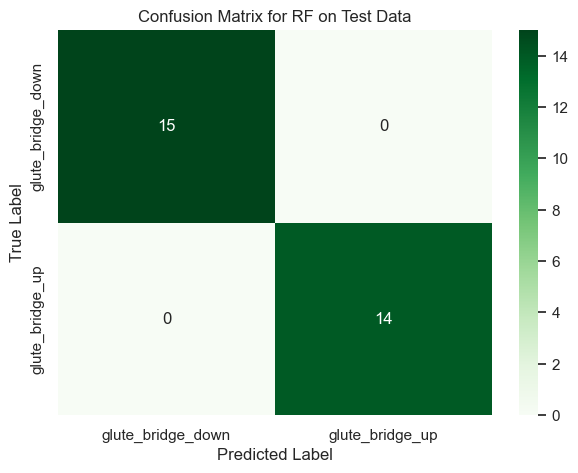

Chosen model pipeline ('RF') saved to: ../models/pkl/RF_model.pkl


In [8]:
all_models_save_path = os.path.join(MODEL_PKL_DIR, "all_trained_model_pipelines.pkl")
with open(all_models_save_path, "wb") as f:
    pickle.dump(trained_pipelines, f)
print(f"\nAll trained pipelines saved to: {all_models_save_path}")

#    >>>>> YOU CAN CHANGE THIS VALUE TO 'LR', 'KNN', 'DT', 'RF', or 'XGB' <<<<<
CHOSEN_MODEL_NAME = 'RF' 

if CHOSEN_MODEL_NAME in trained_pipelines:
    print(f"\n--- Detailed Report and Saving for Chosen Model: '{CHOSEN_MODEL_NAME}' ---")
    
    # Select the chosen pipeline
    chosen_pipeline = trained_pipelines[CHOSEN_MODEL_NAME]
    
    # Generate predictions for the report
    y_pred_chosen = chosen_pipeline.predict(X_test)
    
    # Print classification report
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred_chosen, target_names=target_names))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_chosen)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix for {CHOSEN_MODEL_NAME} on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Save the chosen model pipeline
    model_save_path = os.path.join(MODEL_PKL_DIR, f"{CHOSEN_MODEL_NAME}_model.pkl")
    with open(model_save_path, "wb") as f:
        pickle.dump(chosen_pipeline, f)
    print(f"Chosen model pipeline ('{CHOSEN_MODEL_NAME}') saved to: {model_save_path}")

else:
    print(f"\nError: The chosen model '{CHOSEN_MODEL_NAME}' is not a valid model name.")
    print(f"Please choose from: {list(trained_pipelines.keys())}")